# Fourier Ring Correlation (FRC)

## Concept and Motivation

**Fourier Ring Correlation (FRC)** measures how similar two images are **in the frequency domain** as a function of spatial frequency.
It complements pixel-space metrics such as **PSNR/SSIM** by directly probing **high-frequency fidelity** (textures, thin edges) and exposing artifacts such as **aliasing** and **checkerboard** patterns.

## Definition

Let $F_1(\mathbf{k})$ and $F_2(\mathbf{k})$ be the 2-D Fourier transforms of two images (e.g., an SR output and its ground truth).
FRC computes a normalized correlation **over rings of equal radius** $\lVert \mathbf{k} \rVert = r$:

$$
\mathrm{FRC}(r)=
\frac{\sum_{\mathbf{k}\in \mathcal{R}(r)} F_1(\mathbf{k})\,\overline{F_2(\mathbf{k})}}
{\sqrt{\sum_{\mathbf{k}\in \mathcal{R}(r)} \lvert F_1(\mathbf{k})\rvert^2}\;
 \sqrt{\sum_{\mathbf{k}\in \mathcal{R}(r)} \lvert F_2(\mathbf{k})\rvert^2}}
\;\in\;[0,1].
$$

* **Rings** $\mathcal{R}(r)$: sets of Fourier samples with the same radius $r$ (spatial frequency).
* The **numerator** favors aligned phase/magnitude; the **denominator** normalizes energy, yielding a bounded correlation value.
* Plotting $\mathrm{FRC}(r)$ vs. ring index (or radius) reveals **which frequencies are well reconstructed** (high correlation) and **where oversmoothing/aliasing occurs** (low correlation).

> **Note.** In practice we take the real part of the numerator (if needed) and clip the curve to $[0,1]$. We also exclude the DC ring $(r=0)$ from summaries.

## How It’s Computed (brief)

1. Apply a **2-D FFT** to both images and take the **magnitude spectrum**.
2. Partition the spectrum into **concentric rings** with equal pixel counts.
3. Compute the normalized correlation **per ring** to obtain the **FRC curve** in $[0,1]$ (low → high frequency).

## High-Frequency AUC (Top-25%)

To summarize high-frequency faithfulness in a single number, we average the **top quartile** (highest-frequency 25%) of the FRC curve and report it as **FRC-AUC**.

* **Higher is better** → more faithful textures, fewer aliasing/checkerboard artifacts.
* Unless otherwise stated, we use **Top-25%** rings as the default high-frequency band.

## What the Notebook Shows

### SR Images

We visualize representative SR results (e.g., **Urban100 / img\_024.png**) from RCAN-based networks to contextualize the frequency-domain analysis.

### SPC vs FGA — FRC Curves

We plot per-method FRC curves (e.g., **SPC** vs **FGA**) on the same axes.
Interpretation guide:

* Curves that **stay higher** over mid/high frequencies indicate better texture preservation.
* Crossings at low frequencies are common; differences **near the right end** (high $r$) are most indicative of sharpness vs. artifacts.

### Quartile Rings

For an intuitive view, we split the radial range into **four equal parts** (quartiles) and color each band:

* **Q1**: very low frequencies (global structure)
* **Q2–Q3**: mid frequencies (most textures)
* **Q4**: high frequencies (fine details; ringing/aliasing are most visible)

### Visualization of Top-Quartile (Q4)

We show the **uniform ring index map** and the **Q4 mask** to indicate which spectrum regions contribute to the **FRC-AUC (Top-25%)** summary.

---

**Quick glossary.**
**SPC**: Sub-Pixel Convolution (**PixelShuffle**).
**FGA**: Fourier-Guided Attention (ours).

In [10]:
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_frc_curve(
        radii, curves, labels, 
        title="FRC curves", vline=48,
        fig_size=(12, 5), dpi=300,
        font_size=20, label_font_size=25, title_font_size=15,
        line_width=2.0, grid_alpha=0.4,
        tight=True
):
    rc = {
        "font.size": font_size,
        "axes.labelsize": label_font_size,
        "axes.titlesize": title_font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "lines.linewidth": line_width,
        "font.family": "serif"           # 기본 serif
    }
    plt.rcParams.update(rc)

    COLORS = itertools.cycle(['#D81B60', '#F28E2B', '#1E88E5', "#1BB893"])

    plt.figure(figsize=fig_size, dpi=dpi)

    for curve, lab, col in zip(curves, labels, COLORS):
        plt.plot(radii, curve, label=lab, color=col)

    plt.axvline(vline, color='k', ls='--', lw=1)
    plt.xlabel(r'Ring index')
    plt.ylabel(r'FRC')
    plt.ylim(0, 1.05)
    plt.grid(alpha=grid_alpha)
    plt.legend(frameon=False)
    plt.show()

def calculate_frc_auc(img, img2, num_rho=64, full=False, eps=1e-8, return_frc=False):
    assert img.shape == img2.shape, "Shapes must match"
    # Convert to grayscale if RGB
    if img.ndim == 3 and img.shape[2] == 3:
        img = img.mean(axis=-1)
        img2 = img2.mean(axis=-1)

    h, w = img.shape
    fft1 = np.fft.rfft2(img)
    fft2 = np.fft.rfft2(img2)

    product = fft1 * np.conj(fft2)
    power1 = np.abs(fft1) ** 2
    power2 = np.abs(fft2) ** 2

    # radial distance map
    fy = np.fft.fftfreq(h, d=1.0) * h
    fx = np.fft.rfftfreq(w, d=1.0) * w
    fy2d, fx2d = np.meshgrid(fy, fx, indexing="ij")
    r_map = np.sqrt(fx2d ** 2 + fy2d ** 2)

    # equal‑count bin edges via sorted radii quantiles
    r_flat = np.sort(r_map.flatten())
    total = len(r_flat)
    idxs = (np.linspace(0, total, num_rho + 1)).round().astype(int).clip(max=total - 1)
    bin_edges = r_flat[idxs]

    frc = np.zeros(num_rho, dtype=np.float32)
    eps = 1e-8
    for i in range(num_rho):
        if i == num_rho - 1:
            mask = (r_map >= bin_edges[i]) & (r_map <= bin_edges[i + 1])
        else:
            mask = (r_map >= bin_edges[i]) & (r_map < bin_edges[i + 1])
        if mask.any():
            num = np.abs(np.sum(product[mask]))
            denom = np.sqrt(np.sum(power1[mask]) * np.sum(power2[mask]))
            frc[i] = 0.0 if denom < eps else num / denom

    if not full:
        frc = frc[(num_rho//4) * 3:]

    frc_auc = np.mean(frc)
    if return_frc:
        return frc_auc, frc
    else:
        return frc_auc


## SR images (RCAN, img_024.png of Urban100)

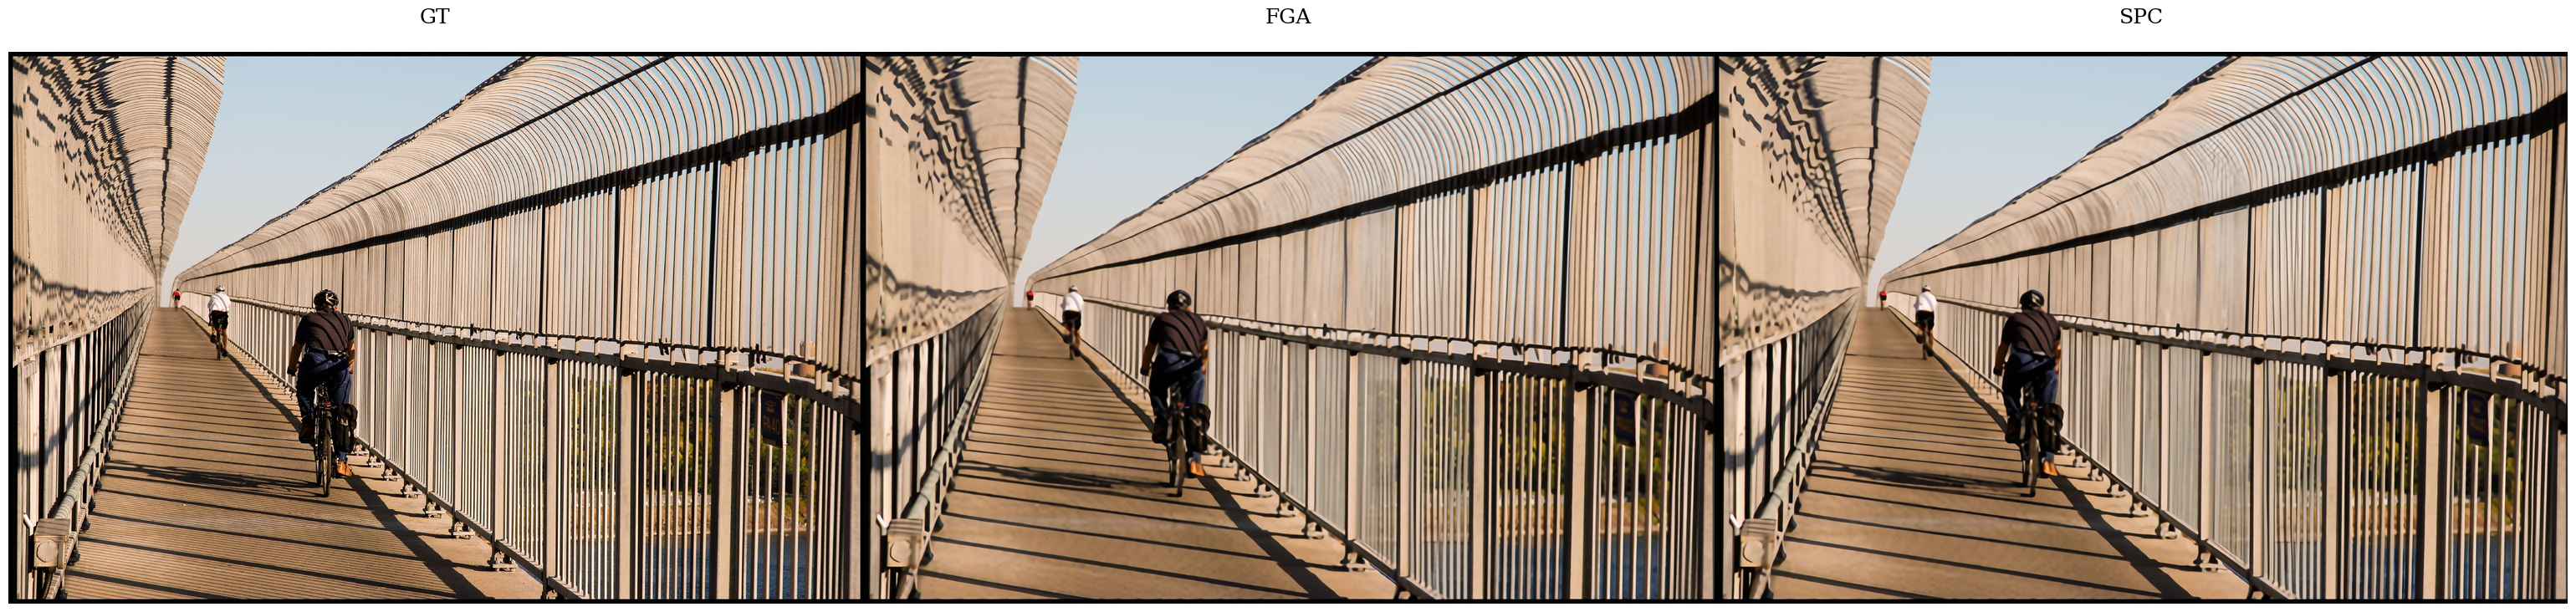

In [11]:
import torch
from vis_utils import load_img, imgs_visualize_row

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GT_PATH = '../assets/img_024.png'
FGA_PATH = '../assets/img_024_RCAN-FGAx4.png'
SPC_PATH = '../assets/img_024_RCANx4.png'

gt = load_img(GT_PATH, device=device)
fga = load_img(FGA_PATH, device=device)
spc = load_img(SPC_PATH, device=device)

imgs_visualize_row([gt, fga, spc], ["GT", "FGA", "SPC"])


## SPC vs FGA — FRC graph


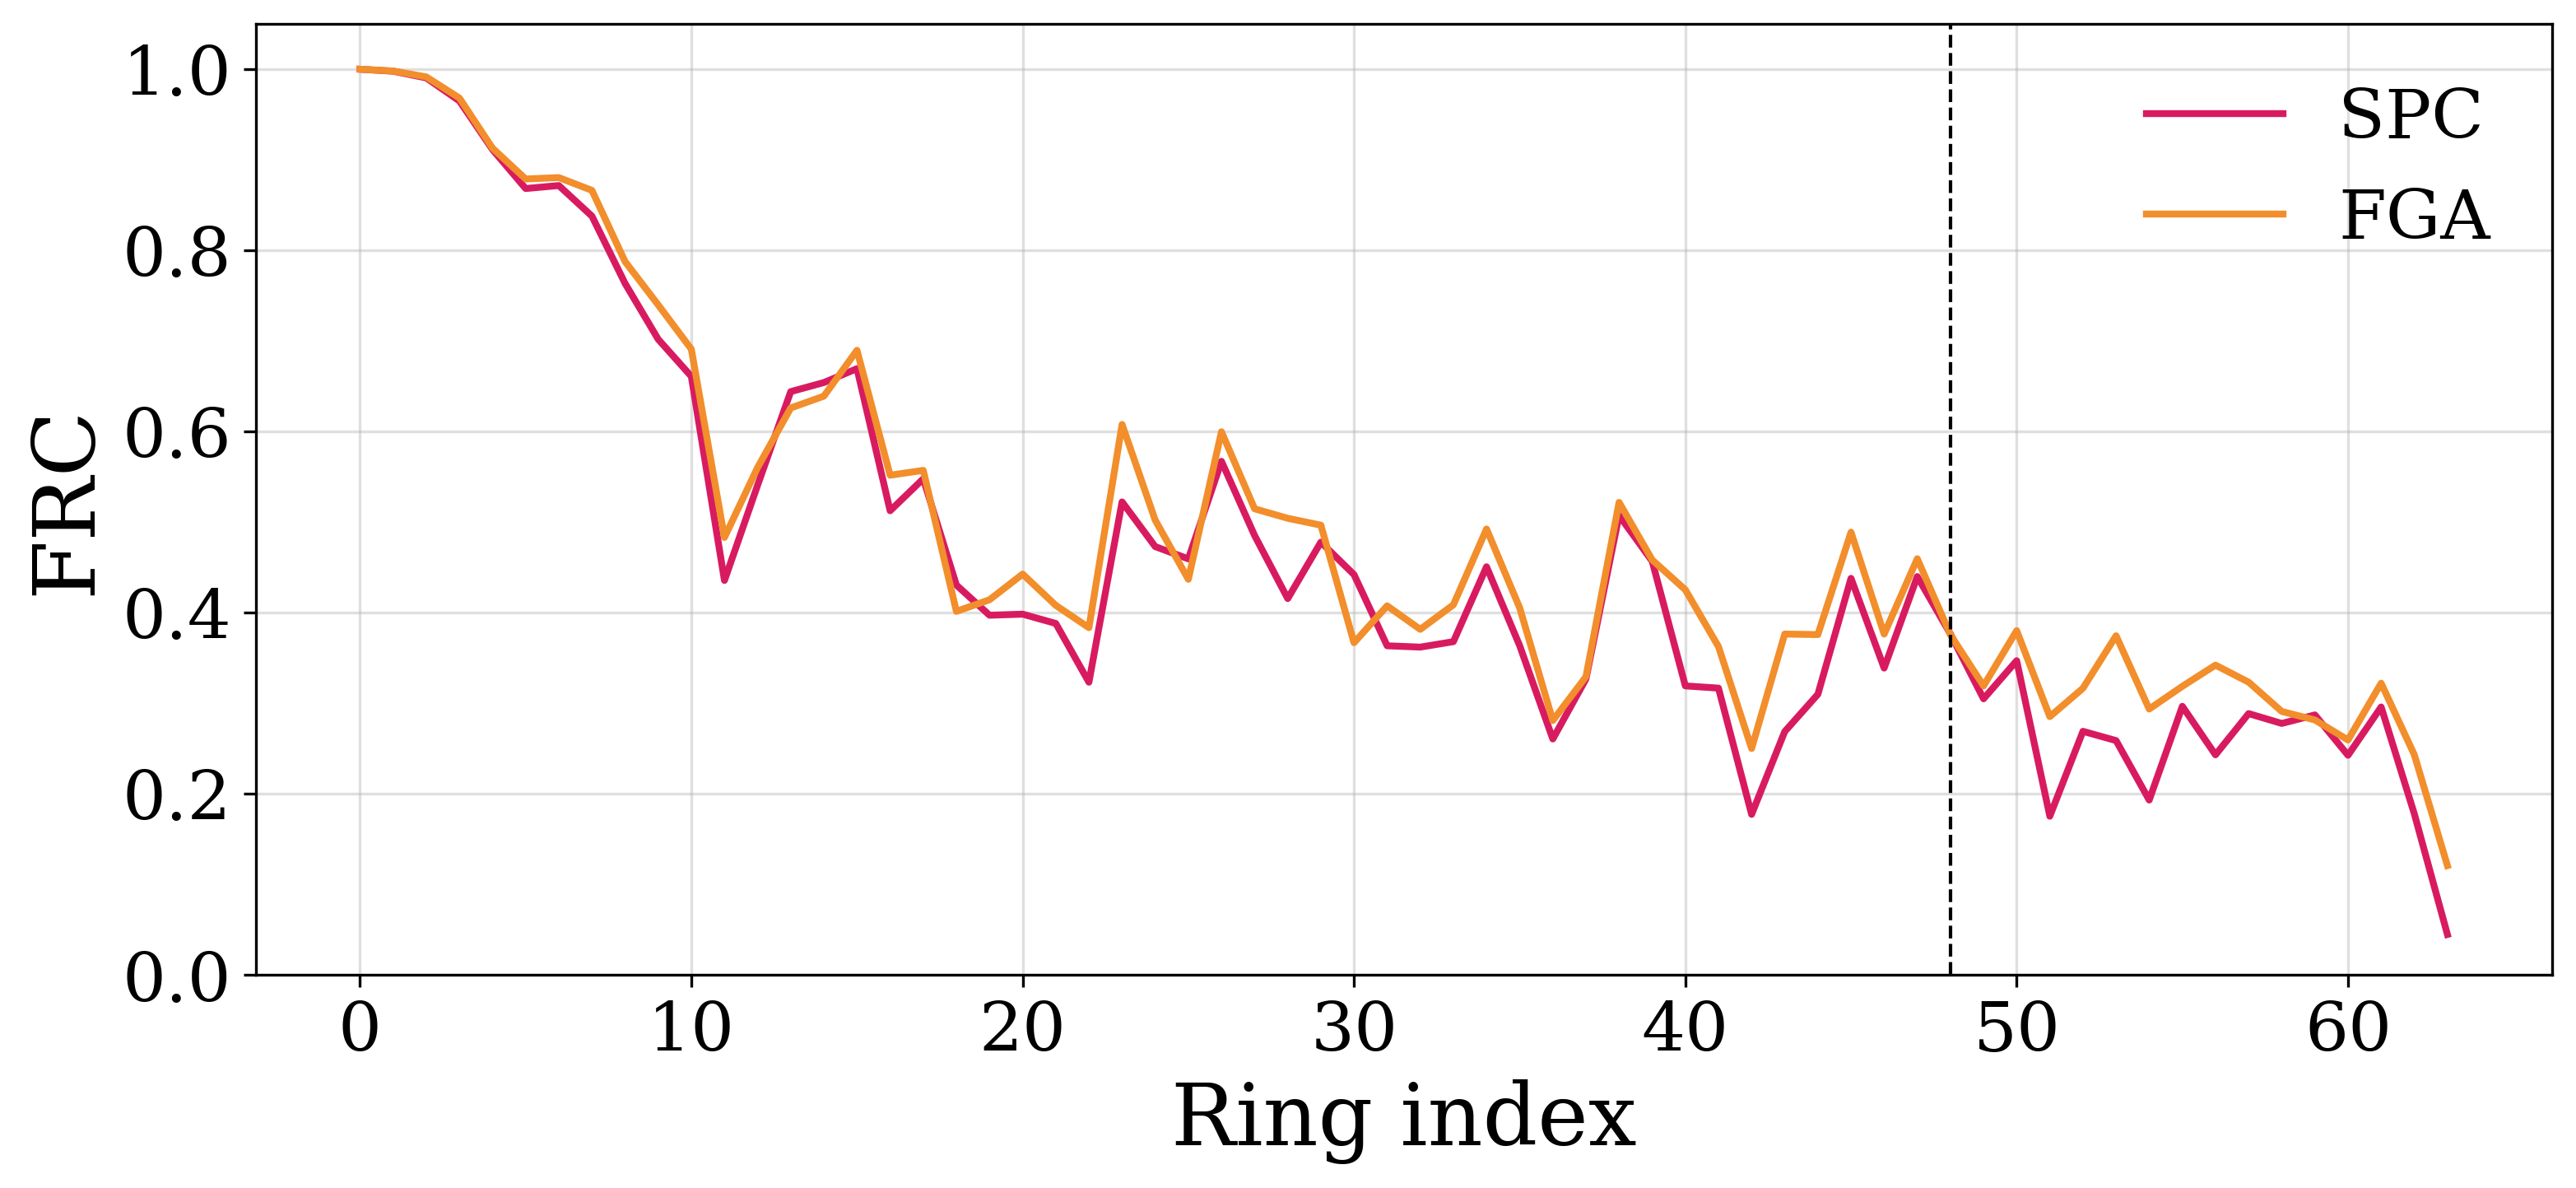

In [12]:
from basicsr.utils.img_util import tensor2img

radii = np.arange(64) # using 64 rings
_, spc_frc = calculate_frc_auc(tensor2img(gt), tensor2img(spc), full=True, return_frc=True)
_, fga_frc = calculate_frc_auc(tensor2img(gt), tensor2img(fga), full=True, return_frc=True)

plot_frc_curve(radii, [spc_frc, fga_frc], ["SPC", "FGA"])


## Quartile Rings
To summarize frequencies coarsely, we split the **radial range** into **four equal parts** (quartiles) and visualize each band:
- Q1: very low frequencies (global structure)
- Q2–Q3: mid frequencies (textures)
- Q4: high frequencies (fine detail; also where ringing/aliasing is most visible)


In [13]:
def fft_radial_bins(h, w, num_bins=64):
    y = np.arange(h) - (h - 1) / 2.0
    x = np.arange(w) - (w - 1) / 2.0
    Y, X = np.meshgrid(y, x, indexing='ij')
    R = np.sqrt(Y**2 + X**2)

    rmax = R.max()
    if num_bins is None:
        num_bins = int(np.ceil(rmax))
    edges = np.linspace(0, rmax, num_bins + 1, dtype=np.float32)
    bin_map = np.digitize(R, edges[1:-1])
    return bin_map, edges, R

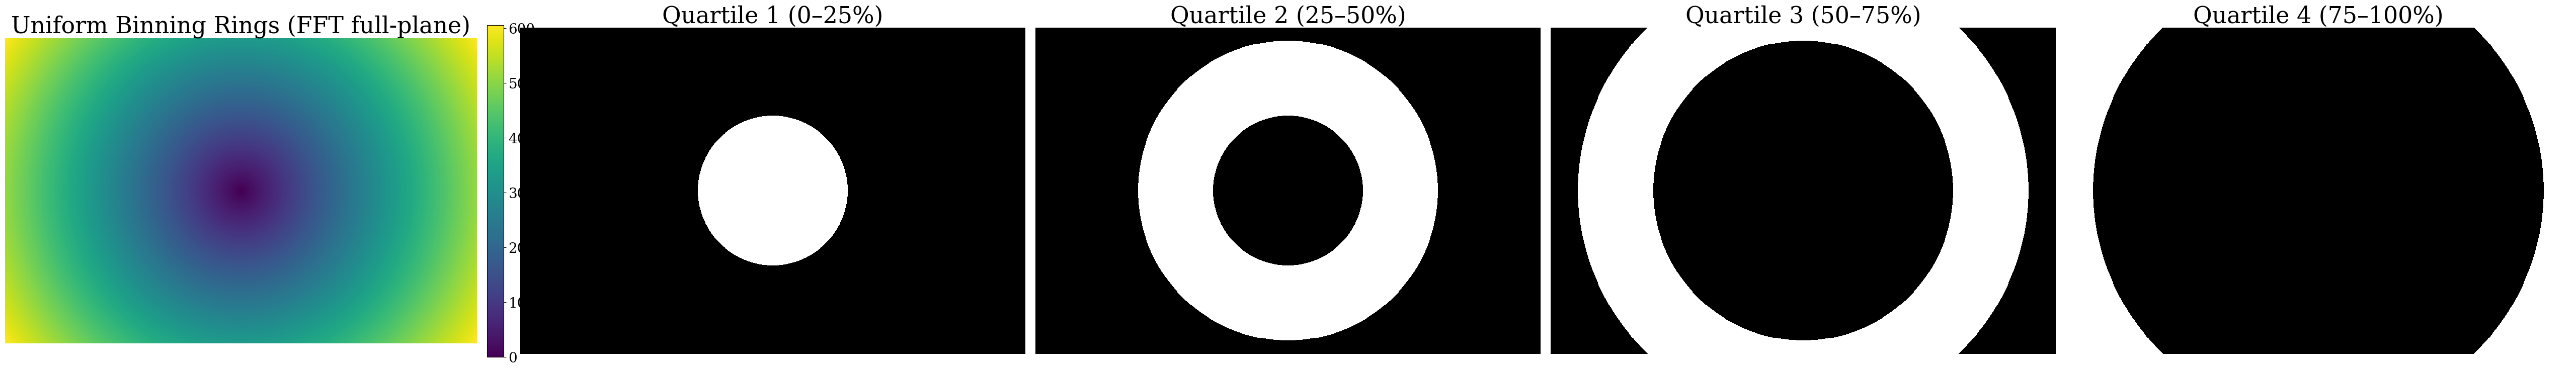

In [14]:
b, c, h, w = gt.shape
bin_map, edges, R = fft_radial_bins(h, w, num_bins=None)

num_bins = int(bin_map.max() + 1)
q_edges  = np.linspace(0, num_bins, 5, dtype=int)
quartile_masks = [(bin_map >= q_edges[i]) & (bin_map < q_edges[i+1]) for i in range(4)]

panels = [bin_map.astype(float)] + [m.astype(float) for m in quartile_masks]
titles = [
    'Uniform Binning Rings (FFT full-plane)',
    'Quartile 1 (0–25%)', 'Quartile 2 (25–50%)',
    'Quartile 3 (50–75%)', 'Quartile 4 (75–100%)'
]
cmaps  = ['viridis', 'gray', 'gray', 'gray', 'gray']

dpi   = int(plt.rcParams.get('figure.dpi', 100))
fig_w = (w * len(panels)) / dpi
fig_h =  h / dpi

fig, axes = plt.subplots(1, len(panels), figsize=(fig_w, fig_h), dpi=dpi)
if len(panels) == 1:
    axes = [axes]

for ax, img, cmap, ttl in zip(axes, panels, cmaps, titles):
    im = ax.imshow(img, cmap=cmap, origin='lower', interpolation='nearest')
    ax.set_title(ttl, fontsize=33, pad=2)
    ax.axis('off')
    ax.set_box_aspect(h / w)

cbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.02)
cbar.set_label('Ring Index')

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.02, hspace=0)
plt.show()



## Visualization of top quartile rings (Quartile 4)

In [ ]:
def extract_q4_vis(img_rgb,
                    pad=32,
                    num_bins=64,
                    hf_start_bin=48,
                    clip_perc=(4,100)
                   ):
    img_pad = np.pad(img_rgb, ((pad,pad),(pad,pad),(0,0)), 'reflect')
    img_pad = img_pad.astype(np.float32)

    h, w, _ = img_pad.shape

    hann2d = np.outer(np.hanning(h).astype(np.float32),
                      np.hanning(w).astype(np.float32))
    img_pad *= hann2d[..., None]

    F = np.fft.rfft2(img_pad, axes=(0,1))

    fy = np.fft.fftfreq(h, 1.0)*h
    fx = np.fft.rfftfreq(w, 1.0)*w
    rho = np.sqrt(fy[:,None]**2 + fx[None,:]**2)

    edges = np.quantile(rho, np.linspace(0,1,num_bins+1))
    mask  = (rho >= edges[hf_start_bin])
    F *= mask[...,None]

    hf = np.fft.irfft2(F, s=(h, w), axes=(0,1)).real
    hf = hf[pad:-pad, pad:-pad].mean(-1)

    p_low, p_hi = clip_perc
    hf_vis = np.clip(hf, *np.percentile(hf, [p_low, p_hi]))
    hf_vis = np.log1p(np.abs(hf_vis))
    hf_vis = (hf_vis - hf_vis.min()) / hf_vis.ptp()

    return (hf_vis * 255).astype(np.uint8)

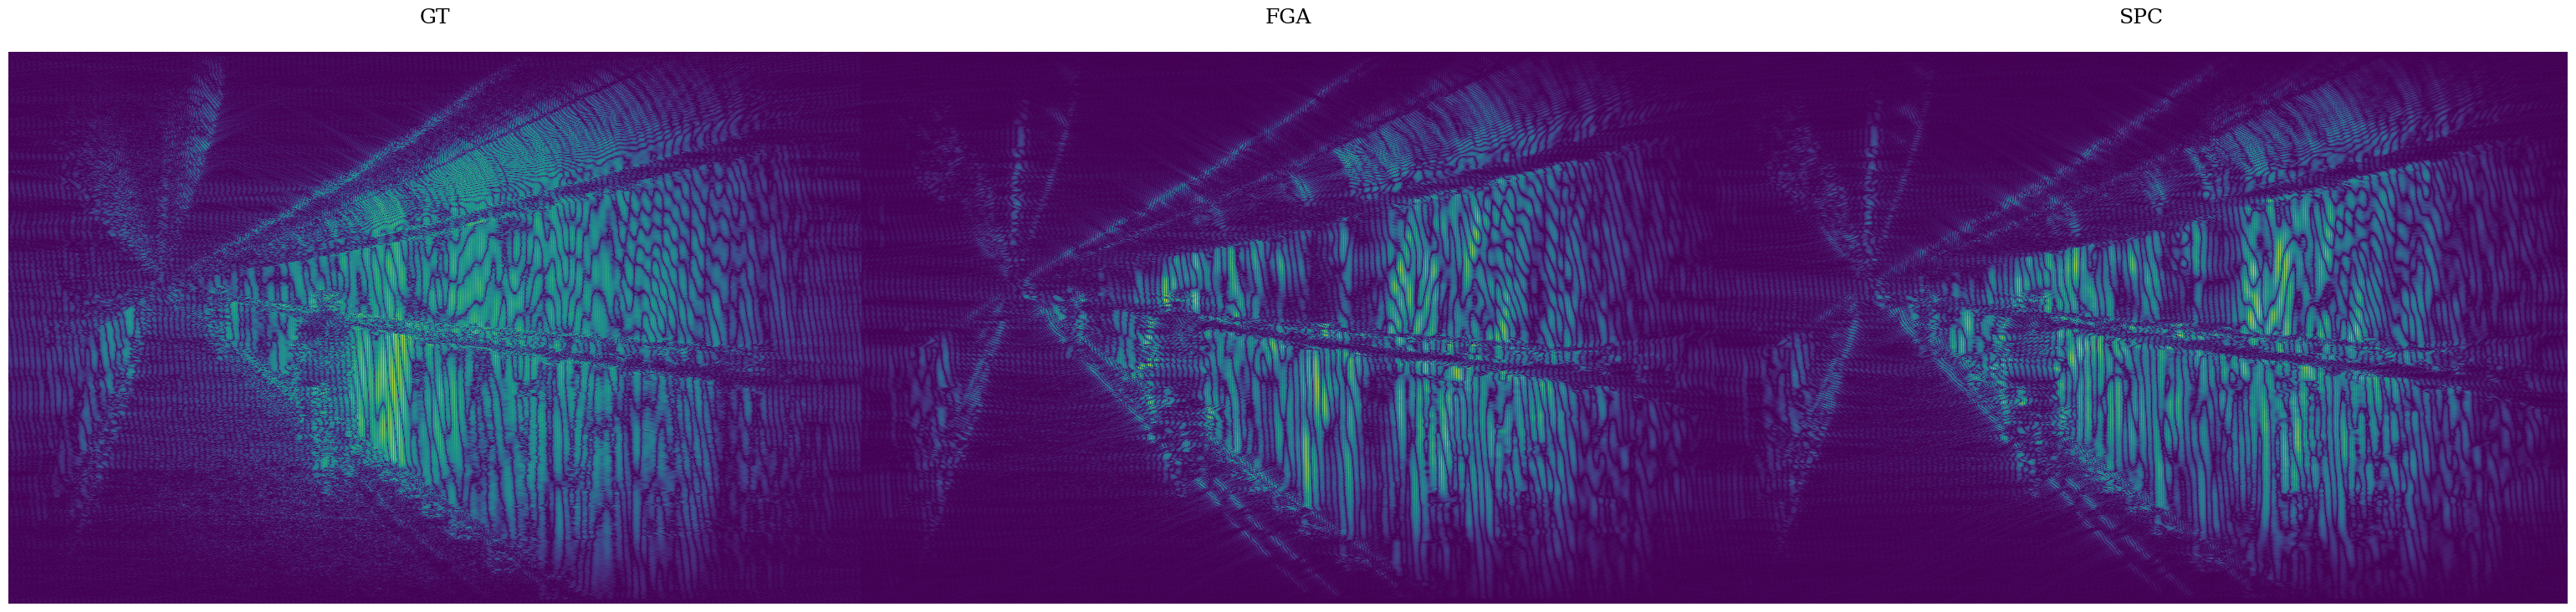

In [ ]:
gt_hf = extract_q4_vis(tensor2img(gt), hf_start_bin=48)
fga_hf = extract_q4_vis(tensor2img(fga), hf_start_bin=48)
spc_hf = extract_q4_vis(tensor2img(spc), hf_start_bin=48)

imgs_visualize_row([gt_hf, fga_hf, spc_hf], ["GT", "FGA", "SPC"])